# DATA PRE-PrOCESSING

This notebook handles the download and pre-rpocessing of the MovieLens 20M Dataset to be used in this TFM.

In [1]:
#Necessary imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from zipfile import ZipFile
import io
from urllib.request import urlopen


## Download the Dataset

Dataset is downloaded in the memory and loaded by directly as dataframes.

In the source data there are 6 CSV files:
1. ratings.csv
2. movies.csv
3. links.csv
4. tags.csv
5. genome-scores.csv
6. genome-tags.csv

For the scope of this TFM, only the ratings.csv, movies.csv and links.csv are used.

In [2]:
#Link of the source data: MovieLens 20M Dataset
movielens_link = "https://files.grouplens.org/datasets/movielens/ml-20m.zip"


#Download and load the dataset
r = urlopen(movielens_link).read()
file = ZipFile(io.BytesIO(r))
df_ratings = pd.read_csv(file.open('ml-20m/ratings.csv'), encoding='latin1')
df_movies = pd.read_csv(file.open('ml-20m/movies.csv'), encoding='latin1')
df_links = pd.read_csv(file.open('ml-20m/links.csv'), encoding='latin1')

df_ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


## Explore the Data

ratings.csv file contains the data required to build the recommendation engine. Due to the nature of the data which is user ratings for movies, the data is very sparse which can be seen in the excerpt of the data shaped as a user-item matrix below.

In [14]:
#Format the dataframe in user-item matrix format to demonstrate the sparse matrix

sparse_matrix_demo = df_ratings.loc[:1000].pivot(index="userId", columns="movieId", values="rating").loc[:10,:20]
#sparse_matrix_demo.to_csv("sparse_demo.csv")
sparse_matrix_demo

movieId,1,2,3,6,7,10,11,15,16,17,19
userId,,,,,,,,,,,
1,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,3.0,NaN,4.0,NaN,NaN,NaN,NaN,3.0
5,NaN,3.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,3.0,NaN
6,5.0,NaN,3.0,NaN,5.0,NaN,NaN,NaN,NaN,5.0,NaN
7,NaN,NaN,3.0,NaN,3.0,NaN,4.0,2.0,3.0,2.0,NaN
8,4.0,NaN,5.0,3.0,NaN,4.0,NaN,NaN,NaN,NaN,1.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


An overview of the distribution of ratings can be seen below.

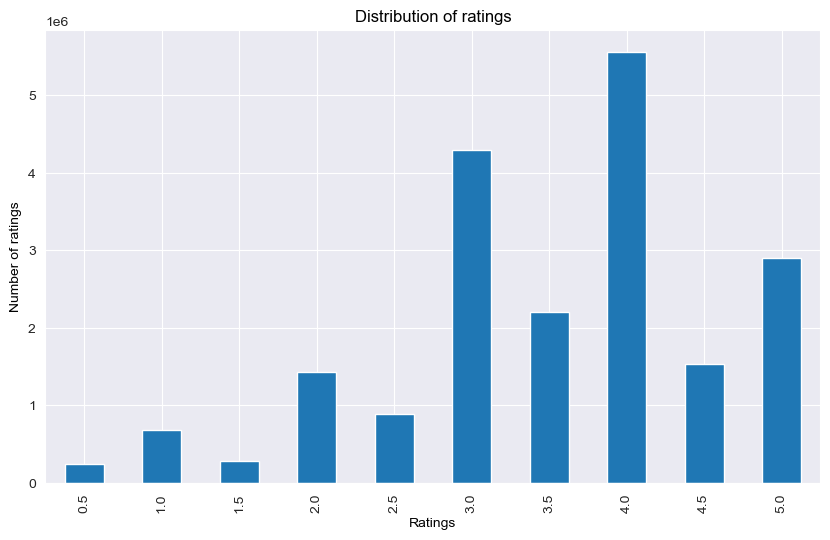

In [15]:
ratings_value_counts = df_ratings['rating'].value_counts().sort_index(ascending=True)

sns.set_style("darkgrid")

plt.figure(figsize=(10,6), dpi=100)
axis = ratings_value_counts.plot.bar()
axis.set_xlabel("Ratings", color="black")
axis.set_ylabel("Number of ratings", color="black")
axis.set_title("Distribution of ratings", color="black");

fig = axis.get_figure()
fig.patch.set_facecolor('white')
#fig.savefig('figures/Distribution of ratings.png',bbox_inches='tight', dpi=100)

### Downsize the data

With exploring certain conditions for users and items (movies), the data can be downsized with less sparsity. This will help with the training processes in the experimentation and reduce the noise.

First, the number of ratings per movie has been investigated to remove less rated movies.

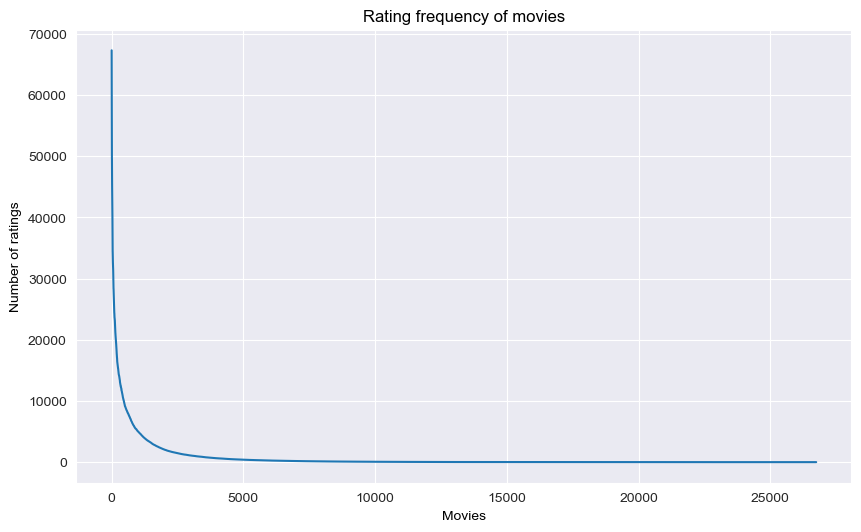

In [16]:
movie_exp_df = df_ratings[['movieId','userId']].groupby(['movieId']).agg(['count']).sort_values(('userId','count'),ascending=False)
 
plt.figure(figsize=(10,6), dpi=100) 
sns.set_style("darkgrid")

sns.lineplot(data=movie_exp_df[('userId', 'count')].values)
plt.title("Rating frequency of movies", color="black")
plt.xlabel("Movies", color="black")
plt.ylabel("Number of ratings", color="black");

#plt.savefig('figures/Rating Freq Movies.png',bbox_inches='tight', dpi=100)

From the figure above, it can be estimated that a big percentage of the movies have approximately less than 500 reviews. 

In [17]:
min_rating_count = 500

number_movies_original= len(df_ratings["movieId"].drop_duplicates())
print(f"Number of movies in the original dataset: {number_movies_original}")

number_movies_new = len(movie_exp_df[movie_exp_df[('userId', 'count')]>=min_rating_count])
print(f"Number of movies which have more than {min_rating_count} ratings: {number_movies_new}")

number_movies_to_remove = number_movies_original-number_movies_new
print(f"Number of movies which have less than {min_rating_count} ratings: {number_movies_to_remove}")

remove_percentage = (number_movies_to_remove/number_movies_original)*100
print(f"Percentage of the movies that will be removed from the dataset: {round(remove_percentage)}%")

Number of movies in the original dataset: 26744
Number of movies which have more than 500 ratings: 4489
Number of movies which have less than 500 ratings: 22255
Percentage of the movies that will be removed from the dataset: 83%


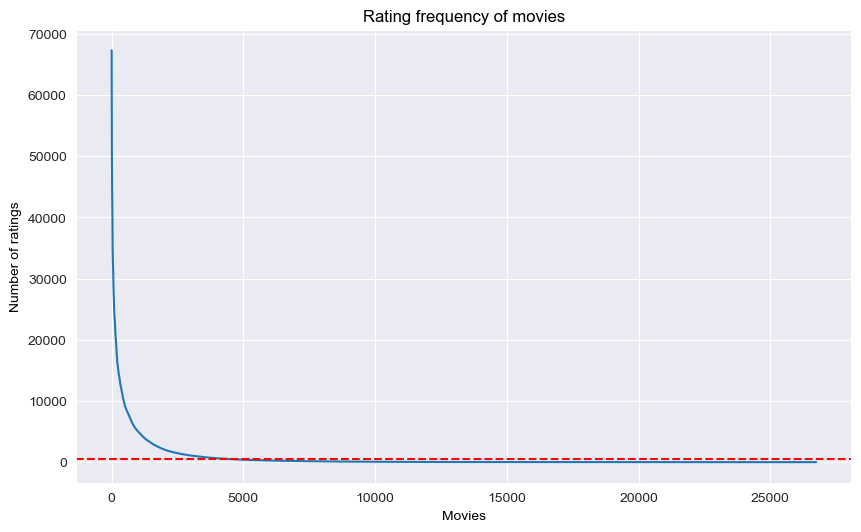

In [18]:
plt.figure(figsize=(10,6), dpi=100) 
sns.set_style("darkgrid")

sns.lineplot(data=movie_exp_df[('userId', 'count')].values)
plt.title("Rating frequency of movies", color="black")
plt.xlabel("Movies", color="black")
plt.ylabel("Number of ratings", color="black");

plt.axhline(y = 500, color = 'r', linestyle = '--');

#plt.savefig('figures/Rating Freq Movies - remove.png',bbox_inches='tight', dpi=100)

In [19]:
#Remove the movies that has less number of ratings than 500.

most_ranked = movie_exp_df[movie_exp_df[('userId', 'count')]>=min_rating_count]

df_most_ranked_movies = df_ratings[df_ratings['movieId'].isin(list(most_ranked.index))]

Second, a similar approach will be conducted for users to be excluded if the user has less than a certain number of ratings done.

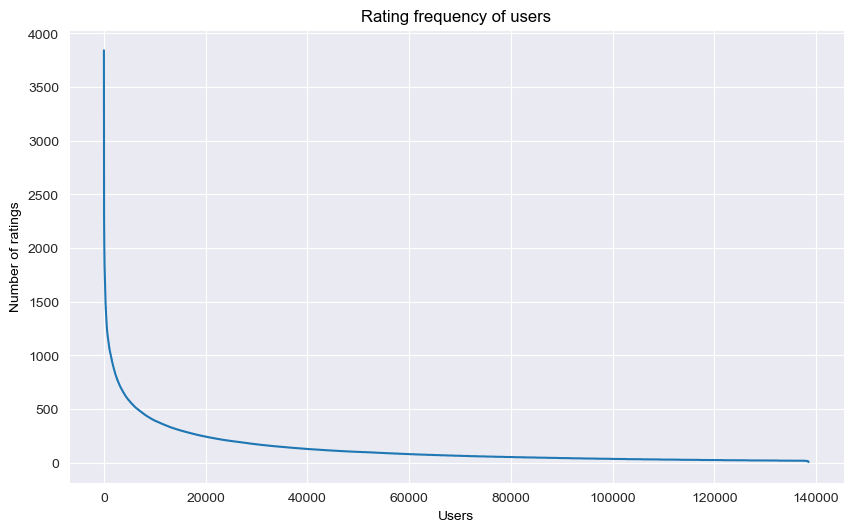

In [20]:
user_exp_df = df_most_ranked_movies[['movieId','userId']].groupby(['userId']).agg(['count']).sort_values(('movieId','count'),ascending=False)

plt.figure(figsize=(10,6), dpi=100) 
sns.set_style("darkgrid")

sns.lineplot(data=user_exp_df[('movieId', 'count')].values)
plt.title("Rating frequency of users", color="black")
plt.xlabel("Users", color="black")
plt.ylabel("Number of ratings", color="black");

#plt.savefig('figures/Rating Freq Users.png',bbox_inches='tight', dpi=100)

From the figure above, it can be estimated that a big percentage of the users have ranked approximately less than 200 movies. 

In [21]:
min_rated_count = 200

number_users_original= len(df_ratings["userId"].drop_duplicates())
print(f"Number of users in the original dataset: {number_users_original}")


number_users_new = len(user_exp_df[user_exp_df[('movieId', 'count')]>=min_rated_count])
print(f"Number of users which have done more than {min_rated_count} ratings: {number_users_new}")

number_users_to_remove = number_users_original-number_users_new
print(f"Number of users which have done less than {min_rated_count} ratings: {number_users_to_remove}")

remove_percentage = (number_users_to_remove/number_users_original)*100
print(f"Percentage of the users that will be removed from the dataset: {round(remove_percentage)}%")

Number of users in the original dataset: 138493
Number of users which have done more than 200 ratings: 25548
Number of users which have done less than 200 ratings: 112945
Percentage of the users that will be removed from the dataset: 82%


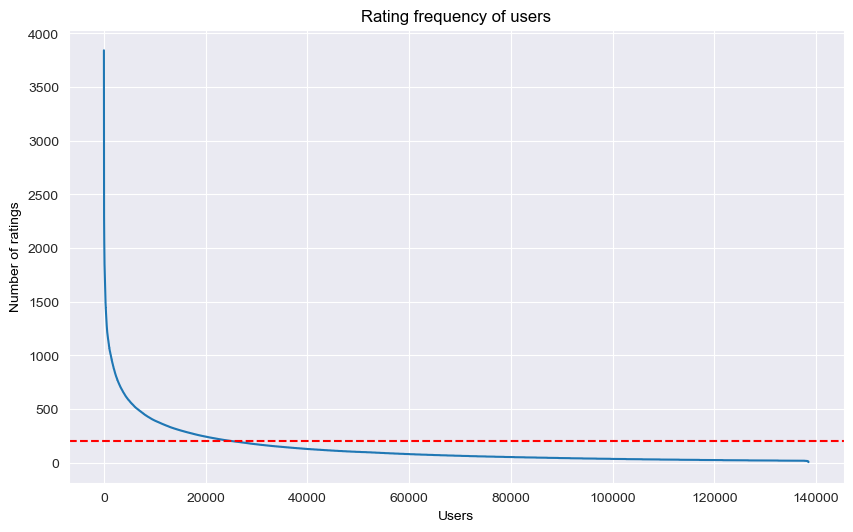

In [22]:
plt.figure(figsize=(10,6), dpi=100) 
sns.set_style("darkgrid")

sns.lineplot(data=user_exp_df[('movieId', 'count')].values)
plt.title("Rating frequency of users", color="black")
plt.xlabel("Users", color="black")
plt.ylabel("Number of ratings", color="black");

plt.axhline(y = 200, color = 'r', linestyle = '--');

#plt.savefig('figures/Rating Freq User - remove.png',bbox_inches='tight', dpi=100)

In [23]:
#Remove the users that has ranked less than 200 movies.

most_ranked_users = user_exp_df[user_exp_df[('movieId', 'count')]>=min_rated_count]

downsized_df = df_most_ranked_movies[df_most_ranked_movies['userId'].isin(list(most_ranked_users.index))]

Now that the movies and users with less rating frequency than the determined thresholds are removed, the remaining data has the following datapoints (ratings) compared with the source data.

In [31]:
num_ranks = len(df_ratings)
new_num_ranks = len(downsized_df)
remove_percentage_ranks = ((num_ranks-new_num_ranks)/num_ranks)*100

print(f"Number of ratings in the original dataset: {num_ranks}")
print(f"Number of ratings in the downsized dataset: {new_num_ranks}")
print(f"Number of ratings removed: {num_ranks-new_num_ranks}")
print(f"Percentage of ratings removed: {round(remove_percentage_ranks)}%")


Number of ratings in the original dataset: 20000263
Number of ratings in the downsized dataset: 11155339
Number of ratings removed: 8844924
Percentage of ratings removed: 44%


## Merge Files

While for the recemmender engine it is sufficient to use the data available in ratings.csv file, in the future steps the information from movies.csv and links.csv will be utilized. Therefore, a master dataframe is generated here for consistency reasons.

In [32]:
df_with_movies = pd.merge(downsized_df, df_movies, how='left', on="movieId")
master_df = pd.merge(df_with_movies, df_links, how='left', on="movieId")

Because the corresponding information of the IDs from other tables has already been merged, for consistency reasons, the user IDs should be re-assigned. 
Same is done for movieID as well, but in a dfiferent way because the movie IDs in this dataset are corresponding to the actual IDs in the MovieLens source. Therefore, the original movieIDs are stored in a new column calles "movielensID", and the movieId column has been re-assigned with new IDs.

In [33]:
master_df = master_df.sort_values(["userId", "movieId"], ascending=True)
master_df["userId"] = master_df["userId"].astype('category').cat.codes 
master_df["movielensId"] = master_df["movieId"]
master_df["movieId"] = master_df["movieId"].astype('category').cat.codes

"tmdbId" column which represents the movie codes for The Movie Database is removed because it is missing the IDs of some movies.

In [34]:
master_df = master_df.drop("tmdbId", axis=1)

In [35]:
#File is saced as zip since it is space consuming
master_df.to_csv("data/master_data_with_movie_info.zip", index=False, compression={'method': 'zip', 'archive_name': 'master_data_with_movie_info.csv'})
master_df

,userId,movieId,rating,timestamp,title,genres,imdbId,movielensId
0,0,2,3.0,1011208463,Grumpier Old Men (1995),Comedy|Romance,113228,3
1,0,6,3.0,1011208220,Sabrina (1995),Comedy|Romance,114319,7
2,0,10,4.0,1011207889,"American President, The (1995)",Comedy|Drama|Romance,112346,11
3,0,14,2.0,1011208732,Cutthroat Island (1995),Action|Adventure|Romance,112760,15
4,0,15,3.0,1011205378,Casino (1995),Crime|Drama,112641,16
...,...,...,...,...,...,...,...,...
11155334,25547,4181,4.5,1260209720,X-Men Origins: Wolverine (2009),Action|Sci-Fi|Thriller,458525,68319
11155335,25547,4188,4.5,1258126920,Up (2009),Adventure|Animation|Children|Drama,1049413,68954
11155336,25547,4195,4.5,1259865108,Transformers: Revenge of the Fallen (2009),Action|Adventure|Sci-Fi|IMAX,1055369,69526
11155337,25547,4198,3.0,1260209457,Ice Age: Dawn of the Dinosaurs (2009),Action|Adventure|Animation|Children|Comedy|Rom...,1080016,69644


Same file but without the additional columns that are not required until further steps will also be generated for convenience of use in experimentation as the dataset is still big.

In [36]:
without_movie_info_df = master_df.drop(["title", "genres", "imdbId", "movielensId"], axis=1)
without_movie_info_df.to_csv("data/master_data.csv", index=False)
without_movie_info_df

,userId,movieId,rating,timestamp
0,0,2,3.0,1011208463
1,0,6,3.0,1011208220
2,0,10,4.0,1011207889
3,0,14,2.0,1011208732
4,0,15,3.0,1011205378
...,...,...,...,...
11155334,25547,4181,4.5,1260209720
11155335,25547,4188,4.5,1258126920
11155336,25547,4195,4.5,1259865108
11155337,25547,4198,3.0,1260209457


Validation that the final dataset is complete and does not have any missing values

In [37]:
master_df.isna().sum()

userId         0
movieId        0
rating         0
timestamp      0
title          0
genres         0
imdbId         0
movielensId    0
dtype: int64